<a href="https://colab.research.google.com/github/NaufalSyahandra/PCVK_GANJIL_2024/blob/main/Week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practicum 6 - Histogram, Histogram Equalization, Dithering**

## **Task 1 - Histogram**


---



### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Library

In [2]:
from google.colab.patches import cv2_imshow
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import glob

### Function to Show plot Histogram

In [3]:
def show_histogram(hist_red, hist_green, hist_blue):
  # create plot for width = 20 and heigth 5
  plt.figure(figsize=(20, 5))

  # create subplot for 1 row three column in 1st subplot
  # this for red channel
  plt.subplot(131)
  plt.bar(range(256), hist_red, color='r')
  # Set the same y-axis limit for all subplots
  max_y = max(hist_red.max(), hist_green.max(), hist_blue.max())
  plt.ylim(0, max_y)
  # set label x,y and title
  plt.xlabel('Intensity Value')
  plt.ylabel('Pixel Count')
  plt.title('Red Channel Histogram')

  # create subplot for 1 row three column in 2nd subplot
  # this for green channel
  plt.subplot(132)
  plt.bar(range(256), hist_green, color='g')
  # Set the same y-axis limit for all subplots
  max_y = max(hist_red.max(), hist_green.max(), hist_blue.max())
  plt.ylim(0, max_y)
  # set label x,y and title
  plt.xlabel('Intensity Value')
  plt.ylabel('Pixel Count')
  plt.title('Green Channel Histogram')

  # create subplot for 1 row three column in 3rd subplot
  # this for blue channel
  plt.subplot(133)
  plt.bar(range(256), hist_blue, color='b')
  # Set the same y-axis limit for all subplots
  max_y = max(hist_red.max(), hist_green.max(), hist_blue.max())
  plt.ylim(0, max_y)
  # set label x,y and title
  plt.xlabel('Intensity Value')
  plt.ylabel('Pixel Count')
  plt.title('Blue Channel Histogram')

  # Add combined histogram plot
  # create each original color channel
  plt.figure(figsize=(20, 5))
  plt.bar(range(256), hist_red, color='r', alpha=0.5, label='Red Channel')
  plt.bar(range(256), hist_green, color='g', alpha=0.5, label='Green Channel')
  plt.bar(range(256), hist_blue, color='b', alpha=0.5, label='Blue Channel')
  # Create custom legend entries for the combinations
  from matplotlib.lines import Line2D
  # Define custom legend handles for combinations
  custom_legend_elements = [
      Line2D([0], [0], color='m', lw=8, label='Red + Green'),
      Line2D([0], [0], color='c', lw=8, label='Green + Blue'),
      Line2D([0], [0], color='y', lw=8, label='Red + Blue'),
      Line2D([0], [0], color='darkblue', lw=8, label='Red + Green + Blue')
  ]
  plt.title('Combined Histogram of RGB Channels')
  plt.xlabel('Intensity Value')
  plt.ylabel('Pixel Count')
  # plt.legend(loc='upper right')
  # Add legend for original channels and custom combinations
  plt.legend(loc='upper right', handles=plt.gca().get_legend_handles_labels()[0] + custom_legend_elements)


  plt.show()

### Manual image Histogram

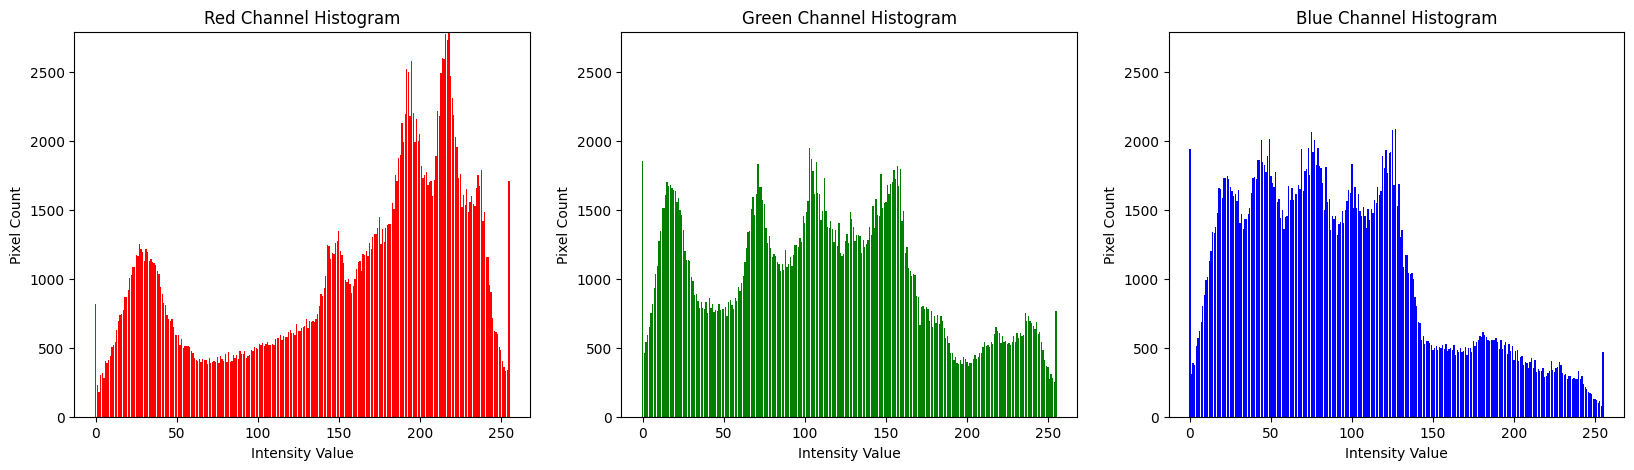

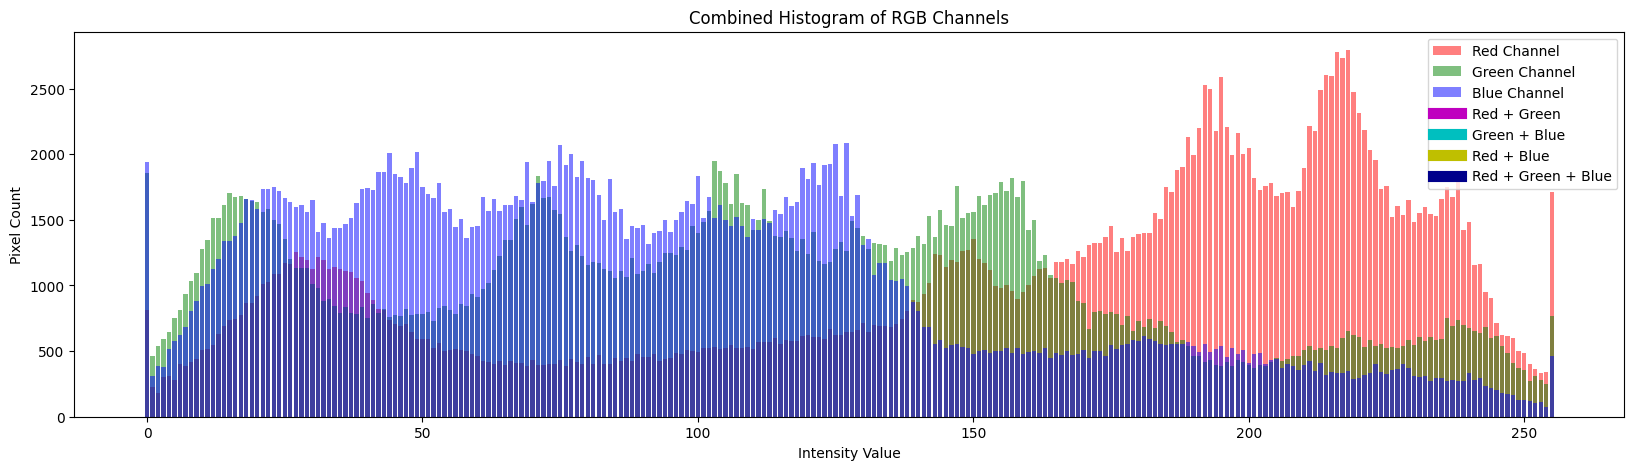

In [5]:
# read image
lena_img = io.imread('/content/drive/MyDrive/PCVK/lena.jpg')
# you can show image like this:
  # for BGR color format
  # cv2_imshow(lena_img)
  #for RGB color format
  # plt.imshow(lena_img)
  # plt.axis('off')
  # plt.show()

# initialize numpy array with 0 value in array 1D
# with 256 index for 0-255 color range
# create 3 different array for Red, Green, and Blue histogram
hist_red = np.zeros(256, dtype=int)
hist_green = np.zeros(256, dtype=int)
hist_blue = np.zeros(256, dtype=int)

# you can built with 2 for looping for y and x coordinate like this:
# for y in range(lena_img.shape[0]):
#   for x in range(lena_img.shape[1]):
#     # count value for each channel
#     hist_red[lena_img[y, x, 0]] += 1
#     hist_green[lena_img[y, x, 1]] += 1
#     hist_blue[lena_img[y, x, 2]] += 1

# but I'm prefere use zip for simple yet compact code
for r, g, b in zip(lena_img[:, :, 0].flatten(), lena_img[:, :, 1].flatten(),lena_img[:, :, 2].flatten()):
  # each color channel, acces bin(intensity color range from 0-255) img, add 1
  # for count histogram in those bin
  # Example: In the Red channel of an image, if a pixel has a Red intensity
  # value of 150, the bin corresponding to 150 bin or index 150
  #  in the histogram will be incremented by 1, because that intensity (150)
  # appeared once in the image
  # at that pixel. If another pixel also has a Red value of 150, that same bin
  # (bin 150) will be incremented again.
  hist_red[r] += 1
  hist_green[g] += 1
  hist_blue[b] += 1

show_histogram(hist_red, hist_green, hist_blue)

### Histogram with numpy histogram() function

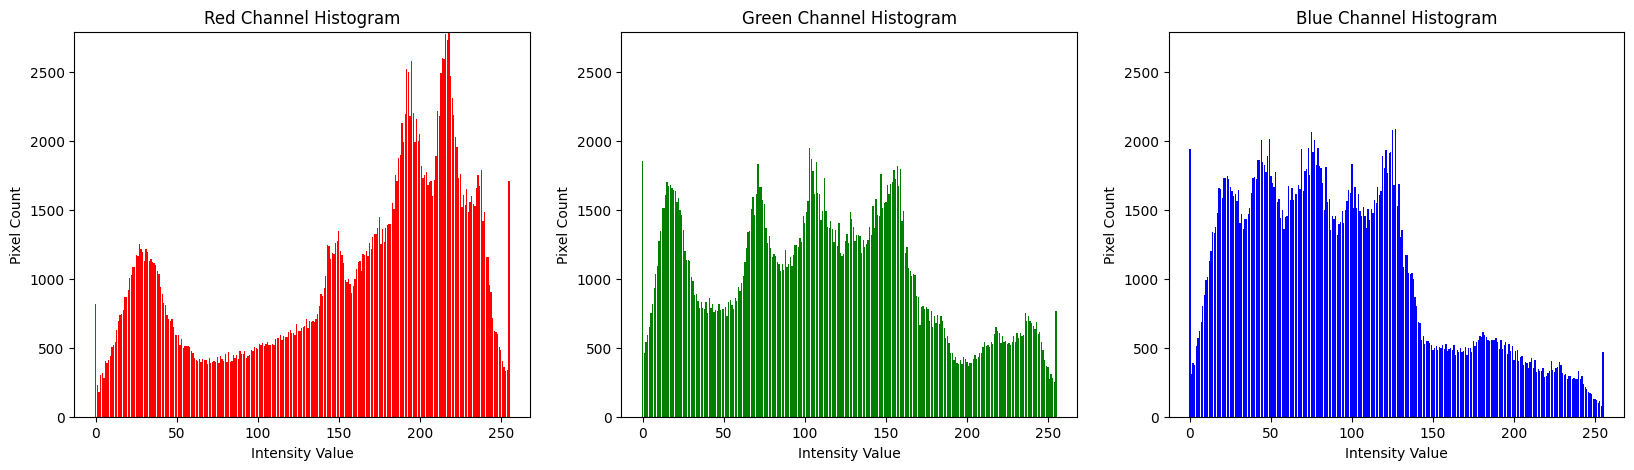

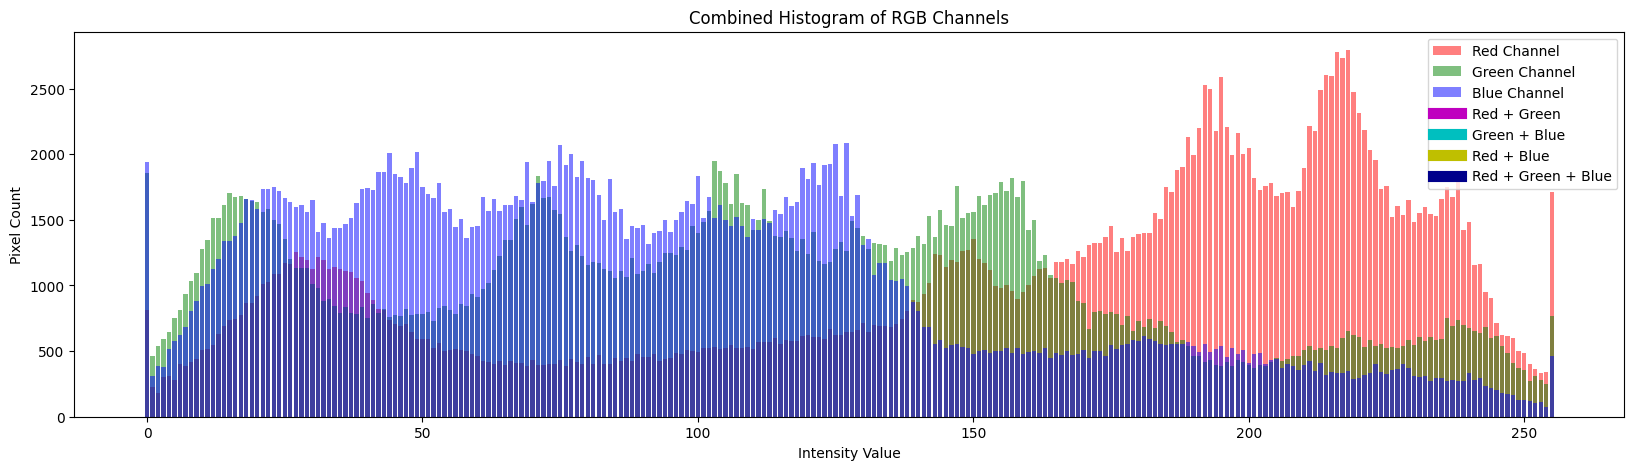

In [6]:
# count histogram range bin from 0-255(256 count) and retrieve just bin count
# in index 0 not bind edges in index 1
hist_red = np.histogram(lena_img[:, :, 0], bins=256, range=(0, 256))[0]
hist_green = np.histogram(lena_img[:, :, 1], bins=256, range=(0, 256))[0]
hist_blue = np.histogram(lena_img[:, :, 2], bins=256, range=(0, 256))[0]

show_histogram(hist_red, hist_green, hist_blue)

## **Task 2 - Histogram Equalization**


---



### Manual Histogram Equalization

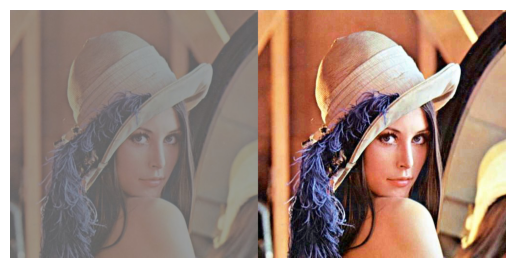

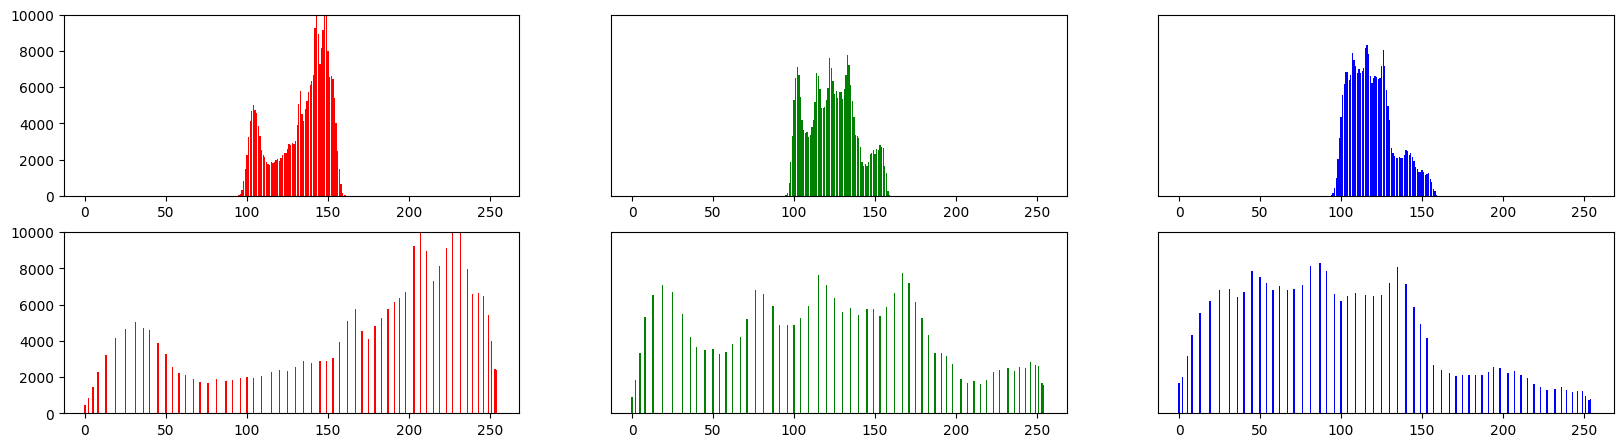

In [9]:
import cv2 as cv

# Create a function to calculate the histogram of a single image channel
def calculate_histogram(image_channel):
  # Flatten the 2D image channel array into a 1D array and count occurrences
  # np.bincount counts the number of occurrences
  # of each integer value in the array.
  # The parameter 'minlength=256' ensures that the output array has a length of
  # 256,corresponding to pixel values ranging from 0 to 255.
  histograms = np.bincount(image_channel.flatten(), minlength=256)

  # Return the histogram array, where each index represents the count of that pixel value
  return histograms

# Function to calculate cumulative distribution fot transform histogram
def cumulative_distribution(histograms):
  # Calculate the cumulative sum of the histogram values.
  # np.cumsum computes the cumulative sum along a given axis, resulting in an array
  # where each element at index 'i' represents the sum of all histogram values
  # from index 0 to index 'i'.
  # Example: If histograms = [3, 5, 2, 0, 1],
  #          then np.cumsum(histograms) gives cd = [3, 8, 10, 10, 11]
  cd = np.cumsum(histograms)

  # Normalize the cumulative distribution to the range [0, 255].
  # This scales the values so that the maximum cumulative value corresponds to 255,
  # which is the highest value for an 8-bit RGB image.
  # np.floor is used to round down to the nearest integer.
  # cd[-1] is the last element of the cumulative distribution, which is the total number of pixels.
  # Continuing the example with cd = [3, 8, 10, 10, 11]:
  # Total number of pixels = cd[-1] = 11
  # Normalized values = floor(255 * cd / 11):
  #   - For index 0: floor(255 * 3 / 11) = floor(69.09) = 69
  #   - For index 1: floor(255 * 8 / 11) = floor(185.45) = 185
  #   - For index 2: floor(255 * 10 / 11) = floor(231.82) = 231
  #   - For index 3: floor(255 * 10 / 11) = floor(231.82) = 231
  #   - For index 4: floor(255 * 11 / 11) = floor(255) = 255
  # Resulting in: [69, 185, 231, 231, 255]
  return np.floor(255 * cd / cd[-1]).astype(np.uint8)

# Function to perform histogram equalization
def histogram_equalization(img):
  # Calculate the histogram of the input image.
  # This function returns an array of counts of pixel intensities.
  # Example: If img has pixel values like [0, 1, 0, 2, 2],
  #          then calculate_histogram(img) might return histograms = [2, 1, 2]
  histograms = calculate_histogram(img)

  # Compute the cumulative distribution from the histogram.
  # This results in an array where each pixel value is mapped to its cumulative frequency.
  cd = cumulative_distribution(histograms)

  # Map pixel values directly using the cumulative distribution.
  # The expression cd[img] takes the original pixel values from 'img' as indices
  # and retrieves their corresponding values from the cumulative distribution,
  # effectively equalizing the histogram of the image.
  # Map pixel values directly using the cumulative distribution.
  # If the original img was [0, 1, 0, 2, 2], then:
  # - cd[img] = [cd[0], cd[1], cd[0], cd[2], cd[2]]
  # - Assuming cd = [0, 85, 170, 255], then:
  # - cd[img] = [0, 85, 0, 170, 170]
  # This step replaces each pixel in img with its corresponding value in the cumulative distribution,
  # effectively equalizing the histogram of the image.
  return cd[img]

# read image
lena_lc = io.imread('/content/drive/MyDrive/PCVK/lena_lc.jpg')

# histogram
histograms = calculate_histogram(lena_lc)

# equalize image
equalized_img = histogram_equalization(lena_lc)

# show original and equalized image
final_frame = cv.hconcat([lena_lc, equalized_img])
plt.imshow(final_frame)
plt.axis('off')
plt.show()

# Extract each channel (RGB color) from the image
R = lena_lc[:,:,0]  # Extract the Red channel
G = lena_lc[:,:,1]  # Extract the Green channel
B = lena_lc[:,:,2]  # Extract the Blue channel

# Calculate the histogram for each color channel
hist_r = calculate_histogram(R)  # Histogram for the Red channel
hist_g = calculate_histogram(G)  # Histogram for the Green channel
hist_b = calculate_histogram(B)  # Histogram for the Blue channel

# Create a list of histograms and corresponding color labels for plotting
channels = [hist_r, hist_g, hist_b]  # List containing histograms for R, G, B
colors = ['r', 'g', 'b']  # List of color labels for plotting

# Set up the figure for plotting histograms
plt.figure(figsize=(20, 8))  # Create a figure with specified size

# Loop over each channel to plot the original histograms
for i, channel in enumerate(channels):
  plt.subplot(3, 3, i+1)  # Create a 3x3 grid of subplots; position for the original histogram
  plt.bar(range(256), channel, color=colors[i])  # Bar plot of the histogram for each channel
  plt.ylim([0, 10000])  # Set the y-axis limits for better visualization
  if i != 0:
    plt.yticks([])  # Hide y-ticks for the Green and Blue channels to reduce clutter

# Loop over each channel to plot the equalized histograms
for i, channel in enumerate(channels):
  plt.subplot(3, 3, i+4)  # Create a position in the 3x3 grid for the equalized histogram
  plt.bar(range(256), calculate_histogram(equalized_img[:,:,i]), color=colors[i])  # Bar plot of the equalized histogram
  plt.ylim([0, 10000])  # Set the y-axis limits for consistency
  if i != 0:
    plt.yticks([])  # Hide y-ticks for the Green and Blue channels to reduce clutter

# Display the plots
plt.show()  # Render the figure with the histograms

### Equalize Histogram Using OpenCv

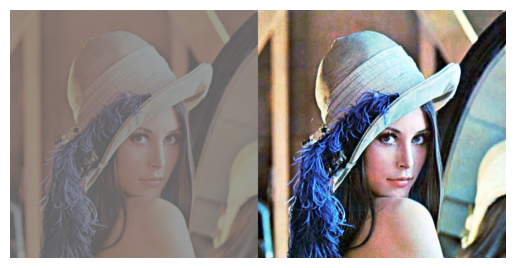

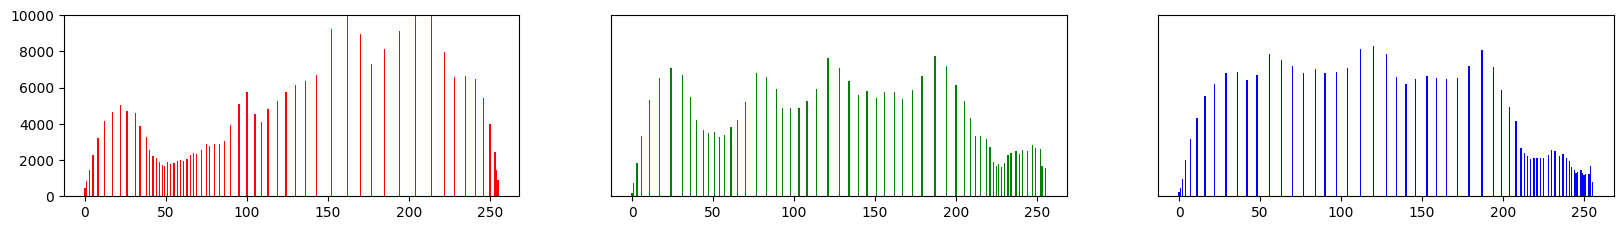

In [10]:
# read image
lena_lc = io.imread('/content/drive/MyDrive/PCVK/lena_lc.jpg')

R = lena_lc[:,:,0]
G = lena_lc[:,:,1]
B = lena_lc[:,:,2]

hist_r = cv.equalizeHist(R)
hist_g = cv.equalizeHist(G)
hist_b = cv.equalizeHist(B)

merge = cv.merge([hist_r, hist_g, hist_b])

final_frame = cv.hconcat([lena_lc, merge])

plt.imshow(final_frame)
plt.axis('off')
plt.show()

channels = [hist_r,hist_g,hist_b]
colors = ['r', 'g', 'b']

plt.figure(figsize=(20, 8))

for i, channel in enumerate(channels):
    plt.subplot(3, 3, i+1)
    plt.bar(range(256), calculate_histogram(channel),color=colors[i])
    plt.ylim([0, 10000])

    if i != 0:
      plt.yticks([])

plt.show()

## **Task 3 - Dithering and Error Difussion**

---



### RGB color mapping from 16 million color to 8 color

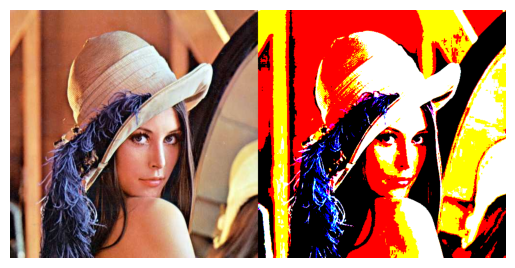

In [11]:
# Function to find the nearest predefined color to a given color
def find_nearest_color(color):
  # Define a dictionary of predefined colors with their RGB values
  colors = {
    'black': [0, 0, 0],
    'green': [0, 255, 0],
    'yellow': [255, 255, 0],
    'blue': [0, 0, 255],
    'cyan': [0, 255, 255],
    'magenta': [255, 0, 255],
    'white': [255, 255, 255],
    'red': [255, 0, 0]
  }

  # Initialize variables to track the nearest color and the minimum distance
  nearest_color = np.array([0, 0, 0])  # Placeholder for the nearest color
  min_distance = float('inf')  # Start with an infinitely large distance

  # Loop through each predefined color to find the closest match
  for name, value in colors.items():
    # Calculate the Euclidean distance between the input color and the predefined color
    distance = np.linalg.norm(np.array(color) - np.array(value))

    # If the current distance is smaller than the previously recorded minimum distance
    if distance < min_distance:
      min_distance = distance  # Update the minimum distance
      nearest_color = np.array(value)  # Update the nearest color

  # Return the RGB value of the nearest color found
  return nearest_color

# Function to map each pixel in the image to its nearest predefined color
def mapping_color(image):
  # Get the dimensions of the input image
  height, width, _ = image.shape

  # Create a copy of the image to store the mapped colors
  img_mapped = image.copy()

  # Iterate over each pixel in the image
  for y in range(height):
    for x in range(width):
      # Extract the RGB value of the current pixel
      color = image[y, x]

      # Find the nearest predefined color using the previously defined function
      nearest_color = find_nearest_color(color)

      # Map the pixel in the new image to the nearest predefined color
      img_mapped[y, x] = nearest_color

  # Return the new image with mapped colors
  return img_mapped


lena = io.imread('/content/drive/MyDrive/PCVK/lena.jpg')

img_mapped = mapping_color(lena)

final_frame = cv.hconcat([lena, img_mapped])

plt.imshow(final_frame)
plt.axis('off')
plt.show()

### Floyd and Steinberg Dithering

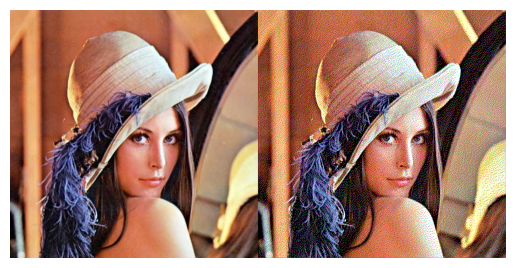

In [12]:
# Function to apply thresholding to ensure pixel values are within [0, 255]
def threshold(value):
    # Clip the pixel values to be within the range [0, 255]
    # np.clip modifies the array 'value' in place, setting any values < 0 to 0
    # and any values > 255 to 255.
    np.clip(value, 0, 255, out=value)

    # Return the modified pixel values
    return value

# Function to apply Floyd-Steinberg dithering algorithm to an RGB image
def floyd_steinberg_dithering(image):
    """Function to apply Floyd-Steinberg Dithering on an RGB image."""

    # Get the dimensions of the input image
    height, width, _ = image.shape

    # Create a copy of the original image for the dithered output
    # Convert the image to float32 to avoid overflow during calculations
    img_dithered = image.copy().astype(np.float32)

    # Loop through each pixel in the image, excluding the last row and column
    for y in range(height - 1):
        for x in range(1, width - 1):
            # Store the original pixel value for reference
            pixel_old = img_dithered[y, x].copy()

            # Set a minimal distance for dithering (usually 1)
            jarak_pixel = 1
            # Calculate the new pixel value based on dithering (rounding the value)
            # The formula rounds the pixel value after normalizing it between 0 and 1,
            # then scales it back to the range [0, 255].
            pixel_new = np.round(jarak_pixel * pixel_old / 255.0) * (255 / jarak_pixel)
            img_dithered[y, x] = pixel_new

            # Calculate the error between the old and new pixel values
            error = pixel_old - pixel_new

            # Distribute the error to neighboring pixels using Floyd-Steinberg coefficients
            img_dithered[y, x + 1] += error * 7 / 16  # Right pixel
            img_dithered[y + 1, x - 1] += error * 3 / 16  # Bottom-left pixel
            img_dithered[y + 1, x] += error * 5 / 16  # Bottom pixel
            img_dithered[y + 1, x + 1] += error * 1 / 16  # Bottom-right pixel

            # Apply thresholding to ensure neighboring pixels remain within [0, 255]
            img_dithered[y, x + 1] = threshold(img_dithered[y, x + 1])
            img_dithered[y + 1, x - 1] = threshold(img_dithered[y + 1, x - 1])
            img_dithered[y + 1, x] = threshold(img_dithered[y + 1, x])
            img_dithered[y + 1, x + 1] = threshold(img_dithered[y + 1, x + 1])

    # Return the dithered image converted back to uint8 format
    return img_dithered.astype(np.uint8)


lena = io.imread('/content/drive/MyDrive/PCVK/lena.jpg')
img_dithered = floyd_steinberg_dithering(lena)

final_frame = cv.hconcat([lena, img_dithered])

plt.imshow(final_frame)
plt.axis('off')
plt.show()

## **Task 4 - Histogram + Dithering grayscale img**

---



### Luminance Grayscale

In [13]:
def grayscale_luminance(image):
  # Create an empty array with the same shape as the input image to hold the grayscale values
  gray_image = np.zeros_like(image)

  # Loop through each pixel in the image
  for y in range(image.shape[0]):  # Iterate over the height (rows)
    for x in range(image.shape[1]):  # Iterate over the width (columns)
      # Calculate the grayscale value using the luminance formula
      gray_image[y, x] = np.dot(image[y, x, :], [0.299, 0.587, 0.114])

  # Return the grayscale image as an unsigned 8-bit integer array
  return gray_image.astype(np.uint8)

### Final process

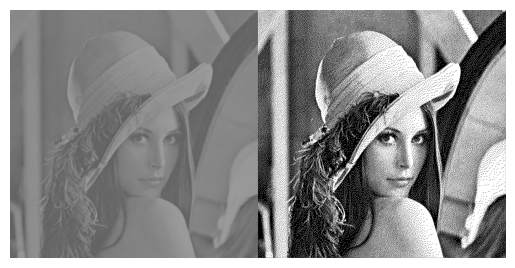

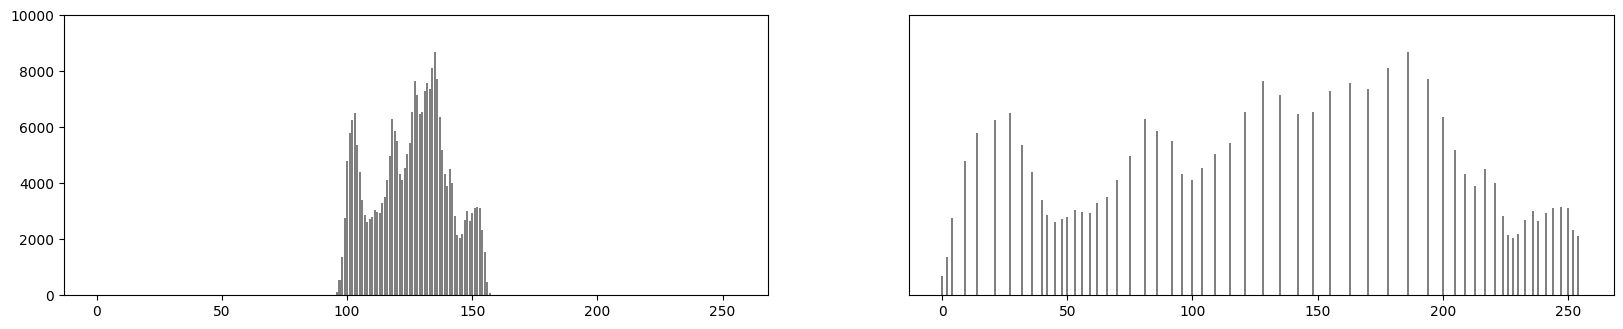

In [14]:
lena_lc = io.imread('/content/drive/MyDrive/PCVK/lena_lc.jpg')

# Convert the original image to grayscale
gray_image = grayscale_luminance(lena_lc.copy())

# Apply histogram equalization to enhance contrast
equalized_img = histogram_equalization(gray_image)

# Apply Floyd-Steinberg dithering to the equalized grayscale image
img_dithered = floyd_steinberg_dithering(equalized_img)

# Combine the grayscale image and the dithered image side by side
final_frame = cv.hconcat([gray_image, img_dithered])

# Display the combined image without axis
plt.imshow(final_frame, cmap='gray')
plt.axis('off')  # Hide axes for better visual presentation
plt.show()  # Render the combined image

# Create a new figure for displaying histograms
plt.figure(figsize=(20, 8))

# Prepare an array of images for histogram plotting
images = np.array([gray_image, equalized_img])

# Loop through each image to plot its histogram
for i, image in enumerate(images):
    plt.subplot(2, 2, i + 1)  # Create a subplot for each histogram
    plt.bar(range(256), calculate_histogram(image[:, :, 0]), color='gray')  # Plot the histogram
    plt.ylim([0, 10000])  # Set y-axis limit for visibility
    if i != 0:
        plt.yticks([])  # Hide y-ticks for the second histogram

plt.show()  # Render the histogram plots